# **Bias Audit Report**

### Reproducible bias audit on the **UCI Adult Income** dataset using **Fairlearn** and **scikit-learn**. It implements multiple fairness metrics, visualizations, statistical testing, and **three:** mitigation techniques (reweighting, Exponentiated Gradient, **ThresholdOptimizer**).

# **Required packages**

In [1]:
# Install required packages
!pip install --quiet fairlearn scikit-learn pandas numpy matplotlib seaborn scipy joblib


## **Standard Imports**

In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

from fairlearn.metrics import MetricFrame, selection_rate, count, demographic_parity_difference,     true_positive_rate, false_negative_rate, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
from fairlearn.postprocessing import ThresholdOptimizer

from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')


### **Preprocessing**

In [3]:
# Load UCI Adult dataset
# We'll load from UCI's hosted CSV Using colab(uses internet).
import urllib.request
url_train = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
url_test = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

cols = [
 'age','workclass','fnlwgt','education','education-num','marital-status',
 'occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income'
]

# Read train & test files
train = pd.read_csv(url_train, names=cols, sep=',\s', engine='python', na_values='?')
test = pd.read_csv(url_test, names=cols, sep=',\s', engine='python', skiprows=1, na_values='?')

# Combine and clean
df = pd.concat([train, test], ignore_index=True)
df['income'] = df['income'].str.replace('.', '', regex=False)
df = df.dropna().reset_index(drop=True)
df['income_label'] = (df['income'] == '>50K').astype(int)

print('Loaded dataset with shape:', df.shape)
df.head()


Loaded dataset with shape: (45222, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [4]:
# Prepare features and preprocessing pipeline
target = 'income_label'
X = df.drop(columns=[target, 'income', 'income_label'])
y = df[target].values

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

numeric_features, categorical_features


(['age',
  'fnlwgt',
  'education-num',
  'capital-gain',
  'capital-loss',
  'hours-per-week'],
 ['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'sex',
  'native-country'])

## 1) **Selection of protected attribute(s) and affected groups**
We'll use **Gender** (Male / Female) as the primary protected attribute.

In [5]:
protected_attr = 'sex'
df[protected_attr].value_counts()

,count
sex,
Male,30527
Female,14695


In [6]:
# Build preprocessing: OneHotEncode categoricals, StandardScale numerics
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Simple logistic pipeline
clf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train/test split (stratify by target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Fit baseline model
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:,1]

print('Baseline accuracy:', accuracy_score(y_test, y_pred))
print('Baseline AUC:', roc_auc_score(y_test, y_proba))



Baseline accuracy: 0.8444755657109162
Baseline AUC: 0.9025850201738833


## 2) Implement quantitative fairness metrics (3+)
Compute metric values overall and disaggregated by protected groups using Fairlearn's MetricFrame.

In [7]:
# ===============================
# Fairness Metrics Setup
# ===============================
from fairlearn.metrics import (
    selection_rate,
    true_positive_rate,
    false_negative_rate,
    false_positive_rate
)
from fairlearn.metrics import MetricFrame
from IPython.display import Markdown, display

# Create MetricFrames using X_test (NOT df_test)
mf_sel = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test[protected_attr]
)

mf_tpr = MetricFrame(
    metrics=true_positive_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test[protected_attr]
)

mf_fnr = MetricFrame(
    metrics=false_negative_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test[protected_attr]
)

mf_fpr = MetricFrame(
    metrics=false_positive_rate,
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=X_test[protected_attr]
)

def explain_metric(name, mf, protected_attr_name="Group"):
    overall = mf.overall
    by_group = mf.by_group

    groups = list(by_group.index)
    vals = list(by_group.values)

    if name.lower() in ["false_negative_rate", "fnr", "fpr", "false_positive_rate"]:
        disadv = groups[vals.index(max(vals))]
        disadv_reason = "higher values indicate worse performance"
    else:
        disadv = groups[vals.index(min(vals))]
        disadv_reason = "lower values indicate worse performance"

    text = f"""
### **{name}**
- **Overall {name}: {overall:.4f}**

#### **By {protected_attr_name}:**
{by_group.to_frame().to_markdown()}

### **Interpretation**
- **Most disadvantaged group:** **{disadv}**
- **Reason:** {disadv_reason}
    """

    display(Markdown(text))

# Run metrics
explain_metric("Selection Rate", mf_sel, protected_attr_name=protected_attr)
explain_metric("True Positive Rate", mf_tpr, protected_attr_name=protected_attr)
explain_metric("False Negative Rate", mf_fnr, protected_attr_name=protected_attr)
explain_metric("False Positive Rate", mf_fpr, protected_attr_name=protected_attr)



### **Selection Rate**
- **Overall Selection Rate: 0.1984**

#### **By sex:**
| sex    |   selection_rate |
|:-------|-----------------:|
| Female |        0.0728929 |
| Male   |        0.258472  |

### **Interpretation**
- **Most disadvantaged group:** **Female**
- **Reason:** lower values indicate worse performance
    


### **True Positive Rate**
- **Overall True Positive Rate: 0.5866**

#### **By sex:**
| sex    |   true_positive_rate |
|:-------|---------------------:|
| Female |             0.456863 |
| Male   |             0.609748 |

### **Interpretation**
- **Most disadvantaged group:** **Female**
- **Reason:** lower values indicate worse performance
    


### **False Negative Rate**
- **Overall False Negative Rate: 0.4134**

#### **By sex:**
| sex    |   false_negative_rate |
|:-------|----------------------:|
| Female |              0.543137 |
| Male   |              0.390252 |

### **Interpretation**
- **Most disadvantaged group:** **Male**
- **Reason:** lower values indicate worse performance
    


### **False Positive Rate**
- **Overall False Positive Rate: 0.0706**

#### **By sex:**
| sex    |   false_positive_rate |
|:-------|----------------------:|
| Female |             0.0224227 |
| Male   |             0.100079  |

### **Interpretation**
- **Most disadvantaged group:** **Female**
- **Reason:** lower values indicate worse performance
    

In [8]:
# Compute group differences (common metrics)
stat_par_diff = mf_sel.difference()
tpr_diff = mf_tpr.difference()
fnr_diff = mf_fnr.difference()

print('Statistical parity difference (sel rate diff):', stat_par_diff)
print('TPR difference:', tpr_diff)
print('FNR difference:', fnr_diff)


Statistical parity difference (sel rate diff): 0.1855793291290026
TPR difference: 0.1528848004840085
FNR difference: 0.15288480048400843


## 3) Identify affected demographic groups
Report which group is disadvantaged according to the metrics.

In [9]:
group_metrics = pd.DataFrame({
    'selection_rate(Who gets approved)': mf_sel.by_group,
    'true positive rate': mf_tpr.by_group,
    'false negative rate': mf_fnr.by_group
}).rename_axis('group').reset_index()


group_metrics['group_name'] = group_metrics['group']
group_metrics = group_metrics.drop(columns=['group'])

group_metrics



,selection_rate(Who gets approved),true positive rate,false negative rate,group_name
0,0.072893,0.456863,0.543137,Female
1,0.258472,0.609748,0.390252,Male


## 4) Visual and statistical representation of bias patterns
We'll show score distributions, prediction rates, and confusion matrices by group, and run a chi-square test on predicted positive rates.

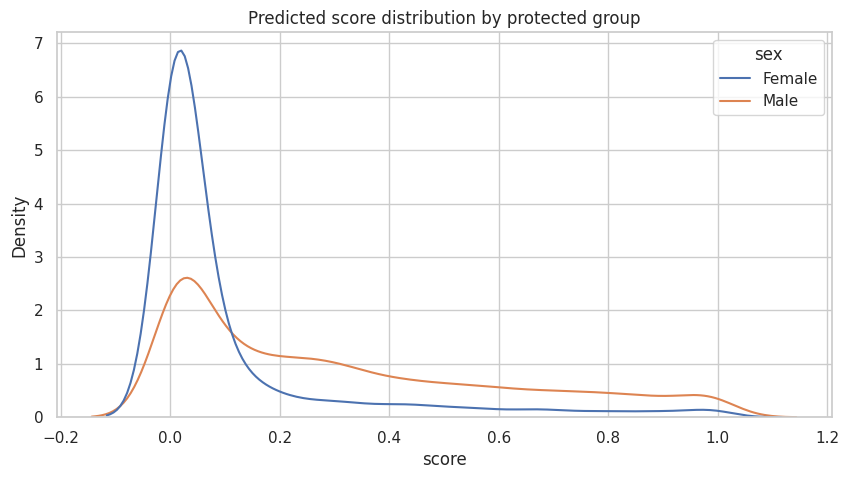

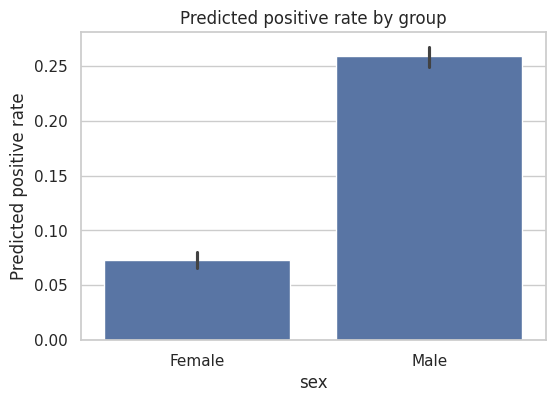

In [10]:
# Add predictions and scores to a DataFrame for plotting
df_test = X_test.copy()
df_test['y_true'] = y_test
df_test['y_pred'] = y_pred
df_test['score'] = y_proba
df_test[protected_attr] = X_test[protected_attr].values

# KDE of scores by group
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_test, x='score', hue=protected_attr, common_norm=False)
plt.title('Predicted score distribution by protected group')
plt.show()

# Prediction rates bar plot
plt.figure(figsize=(6,4))
sns.barplot(x=protected_attr, y='y_pred', data=df_test.astype({ 'y_pred':'int'}), estimator=np.mean)
plt.title('Predicted positive rate by group')
plt.ylabel('Predicted positive rate')
plt.show()



In [11]:
# Chi-square test on predicted positive vs group
contingency = pd.crosstab(df_test[protected_attr], df_test['y_pred'])
chi2, p, dof, expected = chi2_contingency(contingency)
print('Contingency table:\n', contingency)
print(f'Chi-square test: chi2={chi2:.4f}, p-value={p:.4e}')


Contingency table:
 y_pred     0     1
sex               
Female  4070   320
Male    6805  2372
Chi-square test: chi2=641.8234, p-value=1.3409e-141


## 5) Apply 2+ bias mitigation techniques
We'll apply: (1) Reweighting (custom), (2) Exponentiated Gradient (in-processing), **(3) ThresholdOptimizer (post-processing)** — comparing before/after.

In [12]:
# 5a) Reweighting (preprocessing) - custom implementation
# Compute group-label joint probabilities and weights to equalize distribution
train_df = X_train.copy()
train_df['y'] = y_train
train_df[protected_attr] = X_train[protected_attr].values

# Compute weights: inverse of P(group, label) to upweight rare combos
joint = train_df.groupby([protected_attr, 'y']).size().reset_index(name='count')
joint['prob'] = joint['count'] / joint['count'].sum()
# weight = 1 / prob (normalized)
joint['weight_raw'] = 1.0 / joint['prob']
joint['weight'] = joint['weight_raw'] / joint['weight_raw'].mean()

# Map weights back to training examples
weight_map = {(row[protected_attr], row['y']): row['weight'] for _, row in joint.iterrows()}
train_weights = train_df.apply(lambda r: weight_map[(r[protected_attr], r['y'])], axis=1).values

# Fit logistic regression with sample weights
clf_rw = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
clf_rw.fit(X_train, y_train, clf__sample_weight=train_weights)  # sklearn pipeline parameter naming
y_pred_rw = clf_rw.predict(X_test)
y_proba_rw = clf_rw.predict_proba(X_test)[:,1]

print('Reweighing accuracy:', accuracy_score(y_test, y_pred_rw))


Reweighing accuracy: 0.811159430972212


In [13]:
# Evaluate reweighting fairness metrics
# Sensitive attribute used in your notebook
sensitive_feature = X_test['sex']

# Evaluate reweighting fairness metrics
mf_sel_rw = MetricFrame(
    metrics=selection_rate,
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=sensitive_feature
)

mf_tpr_rw = MetricFrame(
    metrics=true_positive_rate,
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=sensitive_feature
)

mf_fnr_rw = MetricFrame(
    metrics=false_negative_rate,
    y_true=y_test,
    y_pred=y_pred_rw,
    sensitive_features=sensitive_feature
)

print('Selection rate by group (reweight):\n', mf_sel_rw.by_group)
print('TPR diff (reweight):', mf_tpr_rw.difference())
print('FNR diff (reweight):', mf_fnr_rw.difference())


Selection rate by group (reweight):
 sex
Female    0.210478
Male      0.403836
Name: selection_rate, dtype: float64
TPR diff (reweight): 0.05350218628825998
FNR diff (reweight): 0.053502186288260034


In [14]:
# 1. Transform the data into numeric arrays
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

# 2. Extract sensitive feature separately (must be a 1D array)
sf_train = X_train[protected_attr].values
sf_test = X_test[protected_attr].values

# 3. Exponentiated Gradient with Demographic Parity
base_estimator = LogisticRegression(max_iter=1000)
constraint = DemographicParity()

expgrad = ExponentiatedGradient(
    estimator=base_estimator,
    constraints=constraint,
    eps=0.01
)

# 4. Fit the mitigated model
expgrad.fit(X_train_trans, y_train, sensitive_features=sf_train)

# 5. Predict label outputs
y_pred_exp = expgrad.predict(X_test_trans)

# 6. Get ensemble prediction scores (Fairlearn older versions)
y_score_exp = expgrad._pmf_predict(X_test_trans)

print("ExpGrad accuracy:", accuracy_score(y_test, y_pred_exp))
print("ExpGrad mean score:", np.mean(y_score_exp))


ExpGrad accuracy: 0.8302498710105403
ExpGrad mean score: 0.5


In [15]:
# Evaluate ExpGrad metrics
mf_sel_exp = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred_exp, sensitive_features=sensitive_feature)
mf_tpr_exp = MetricFrame(metrics=true_positive_rate, y_true=y_test, y_pred=y_pred_exp, sensitive_features=sensitive_feature)
mf_fnr_exp = MetricFrame(metrics=false_negative_rate, y_true=y_test, y_pred=y_pred_exp, sensitive_features=sensitive_feature)

print('Selection rate by group (ExpGrad):\n', mf_sel_exp.by_group)
print('TPR diff (ExpGrad):', mf_tpr_exp.difference())
print('FNR diff (ExpGrad):', mf_fnr_exp.difference())


Selection rate by group (ExpGrad):
 sex
Female    0.163554
Male      0.171189
Name: selection_rate, dtype: float64
TPR diff (ExpGrad): 0.3098726727717735
FNR diff (ExpGrad): 0.30987267277177344


In [16]:
#  Post-processing: ThresholdOptimizer (Equalized Odds or Demographic Parity)
# Train a fresh base model that outputs scores (probabilities)
base_clf = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=1000))])
base_clf.fit(X_train, y_train)
y_proba_base = base_clf.predict_proba(X_test)[:,1]

# ThresholdOptimizer requires the estimator and sensitive_features on training set
thresh = ThresholdOptimizer(estimator=base_clf, constraints="equalized_odds", prefit=True)
thresh.fit(X_train, y_train, sensitive_features=X_train[protected_attr].values)
y_pred_thresh = thresh.predict(X_test, sensitive_features=X_test[protected_attr].values)

print('ThresholdOptimizer accuracy:', accuracy_score(y_test, y_pred_thresh))


ThresholdOptimizer accuracy: 0.8321662858406428


In [17]:
# Evaluate ThresholdOptimizer metrics
mf_sel_th = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred_thresh, sensitive_features=sensitive_feature)
mf_tpr_th = MetricFrame(metrics=true_positive_rate, y_true=y_test, y_pred=y_pred_thresh, sensitive_features=sensitive_feature)
mf_fnr_th = MetricFrame(metrics=false_negative_rate, y_true=y_test, y_pred=y_pred_thresh, sensitive_features=sensitive_feature)

print('Selection rate by group (Threshold):\n', mf_sel_th.by_group)
print('TPR diff (Threshold):', mf_tpr_th.difference())
print('FNR diff (Threshold):', mf_fnr_th.difference())


Selection rate by group (Threshold):
 sex
Female    0.114123
Male      0.199847
Name: selection_rate, dtype: float64
TPR diff (Threshold): 0.006011605203090964
FNR diff (Threshold): 0.006011605203091075


## 6) Compare performance before and after mitigation
We'll create a comparison table showing accuracy and fairness metrics for Base, Reweighting, ExpGrad, and ThresholdOptimizer.

In [18]:
def summarize(name, y_pred, y_proba=None):
    mf_sel = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
    mf_tpr = MetricFrame(metrics=true_positive_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
    mf_fnr = MetricFrame(metrics=false_negative_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature)
    return {
        'method': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'stat_par_diff': mf_sel.difference(),
        'tpr_diff': mf_tpr.difference(),
        'fnr_diff': mf_fnr.difference()
    }

rows = []
rows.append(summarize('Base', y_pred))
rows.append(summarize('Reweighing', y_pred_rw))
rows.append(summarize('ExpGrad(DP)', y_pred_exp))
rows.append(summarize('Threshold(EqOdds)', y_pred_thresh))

pd.DataFrame(rows).set_index('method')


,accuracy,stat_par_diff,tpr_diff,fnr_diff
method,,,,
Base,0.844476,0.185579,0.152885,0.152885
Reweighing,0.811159,0.193357,0.053502,0.053502
ExpGrad(DP),0.830250,0.007635,0.309873,0.309873
Threshold(EqOdds),0.832166,0.085724,0.006012,0.006012


**( 7) Statistical testing to validate bias findings(Difference in selection rates: Male − Female)**

In [19]:
import numpy as np

# Define mask for each group
female_mask = (df_test[protected_attr] == "Female").values
male_mask   = (df_test[protected_attr] == "Male").values

# Compute selection rates
sr_female = y_pred[female_mask].mean()
sr_male   = y_pred[male_mask].mean()
spd = sr_male - sr_female
print("Statistical Parity Difference:", round(spd, 4))

# Bootstrap CI
boot = []
n = len(y_pred)

for _ in range(2000):
    idx = np.random.choice(n, n, replace=True)
    boot_sr_f = y_pred[idx][female_mask[idx]].mean()
    boot_sr_m = y_pred[idx][male_mask[idx]].mean()
    boot.append(boot_sr_m - boot_sr_f)

ci_lower, ci_upper = np.percentile(boot, [2.5, 97.5])
print("95% CI for SPD:", (round(ci_lower, 4), round(ci_upper, 4)))


Statistical Parity Difference: 0.1856
95% CI for SPD: (np.float64(0.1734), np.float64(0.1969))


## **Fairness Research & Frameworks**

**Foundational Fairness Research**

Barocas, S., Hardt, M., & Narayanan, A. (2019). Fairness and Machine Learning.
https://fairmlbook.org

Dwork, C. et al. (2012). Fairness Through Awareness.

Hardt, M., Price, E., & Srebro, N. (2016). Equality of Opportunity in Supervised Learning.

Kleinberg, J., Mullainathan, S., & Raghavan, M. (2017). Inherent Trade-Offs in Algorithmic Fairness.

Friedler, S., Scheidegger, C., et al. (2019). A Comparative Study of Fairness-Enhancing Interventions.

Key Fairness Metrics & Definitions

Mitchell, S. et al. (2018). Prediction-Based Decisions and Fairness: A Catalogue of Fairness Definitions.

Verma, S. & Rubin, J. (2018). Fairness Definitions Explained.

## 8) Recommendations for dataset improvements and ethics framework
- Increase representation of under-represented groups; collect more data if possible.
- Add context variables to reduce proxying by protected attributes.
- Create datasheets and model cards documenting limitations.

Ethics Framework (example):
1. Purpose limitation & risk assessment
2. Stakeholder engagement & human-in-the-loop
3. Transparency & documentation
4. Monitoring & retraining schedules
5. Remediation thresholds and governance
